# Importation des librairies :

In [2]:
import numpy as np
import os
import matplotlib as plt
import tensorflow as tf
import nibabel as nib
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import keras_tuner
import keras
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall, AUC #F1Score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.applications import EfficientNetB0

from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve


physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.compat.v1.disable_eager_execution()

custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue", "yellow", "purple", "deeppink", "brown", "teal", "black"]
sns.set_palette(custom_palette)

# Chargement et traitement des données - IRM Pré traitement :

Nombre de matrices Numpy                 : 100
Nombre de réponse pour la classification : 100


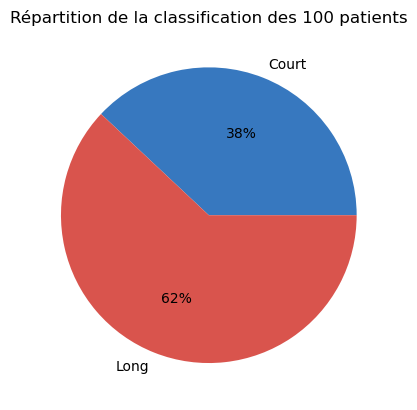

In [71]:
IRMpre_directory  = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/07_Classification_IRMpre"

Matrice_IRMpre_npy = []
Classification     = []

IRMpre = [f for f in os.listdir(IRMpre_directory) if f.endswith('.nii')]
    
for fichier in IRMpre:
    chemin_IRMpre        = os.path.join(IRMpre_directory, fichier)
    label_classification = chemin_IRMpre.split("_")[-4]

    image_IRM = nib.load(chemin_IRMpre)
        
    data = image_IRM.get_fdata()
        
    Matrice_IRMpre_npy.append(data)
    Classification.append(label_classification)
        
print("Nombre de matrices Numpy                 :", len(Matrice_IRMpre_npy))
print("Nombre de réponse pour la classification :", len(Classification))

X = np.array(Matrice_IRMpre_npy)
X = np.expand_dims(X, axis = -1)
X = np.repeat(X, 1, axis = -1)
y = np.array(Classification)

for i in range(len(y)):
    if y[i] == 'Long':
        y[i] = 1
    elif y[i] == 'Court':
        y[i] = 0

labels = ['Court', 'Long']
sizes  = [Classification.count('Court'), Classification.count('Long')]

plt.pie(x = sizes, labels=labels,  autopct='%1.0f%%')
plt.title("Répartition de la classification des 100 patients")
plt.show()
#plt.savefig('Repartition_classification_100patients', dpi = 400)

###### Visualisation des imageries :

Prédiction de la survie du patient : Court


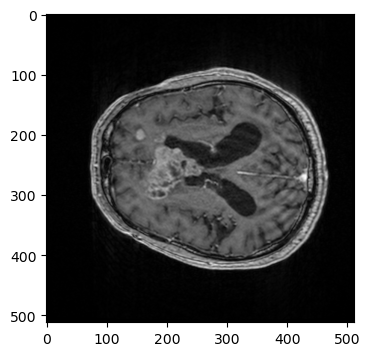

In [11]:
plt.figure(figsize=(4,4))
plt.imshow(X[50], cmap='gray')
print("Prédiction de la survie du patient :",Classification[50])

###### Répartition des données :

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 32)
y_train = to_categorical(y_train, num_classes = 2) ## Uniquement pour softmax
y_val = to_categorical(y_val, num_classes = 2) ## Uniquement pour softmax
y = to_categorical(y, num_classes = 2) ## Uniquement pour softmax

print("\nX_train shape :", X_train.shape)
print("X_val shape   :", X_val.shape)
print("y_train shape :", y_train.shape)
print("y_val shape   :", y_val.shape)


X_train shape : (80, 512, 512, 1)
X_val shape   : (20, 512, 512, 1)
y_train shape : (80, 2)
y_val shape   : (20, 2)


### Modèle CNN basique - Softmax :

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(4, (3,3), activation = 'relu', input_shape = (512,512,1)))
model.add(layers.MaxPooling2D((2,2)))

#model.add(layers.Conv2D(4, (3,3), activation = 'relu'))
#model.add(layers.MaxPooling2D((2,2)))

#model.add(layers.Conv2D(128, (3,3), activation = 'relu'))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

epochs = 500
batch_size = 12
history = model.fit(X_train, y_train, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 4)       40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 4)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 260100)            0         
                                                                 
 dense (Dense)               (None, 32)                8323232   
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 8,323,338
Trainable params: 8,323,338
Non-trainable params: 0
______________________________________________

2024-05-10 12:11:34.168539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:11:34.168756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:11:34.168911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/500


2024-05-10 12:11:34.513186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:11:34.513377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:11:34.513532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

80/80 [==============================] - 1s 19ms/sample - loss: 2801.5040 - accuracy: 0.4375 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 2/500
80/80 [==============================] - 0s 775us/sample - loss: 0.6945 - accuracy: 0.6375 - val_loss: 0.7315 - val_accuracy: 0.5000
Epoch 3/500
80/80 [==============================] - 0s 829us/sample - loss: 0.6924 - accuracy: 0.6250 - val_loss: 0.7385 - val_accuracy: 0.5000
Epoch 4/500
12/80 [===>..........................] - ETA: 0s - loss: 0.6926 - accuracy: 0.5833

/home/aurelien/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-05-10 12:11:36.156635: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:134 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


80/80 [==============================] - 0s 779us/sample - loss: 0.6921 - accuracy: 0.6250 - val_loss: 0.7444 - val_accuracy: 0.5000
Epoch 5/500
80/80 [==============================] - 0s 807us/sample - loss: 0.6917 - accuracy: 0.6250 - val_loss: 0.7475 - val_accuracy: 0.5000
Epoch 6/500
80/80 [==============================] - 0s 776us/sample - loss: 0.6913 - accuracy: 0.6250 - val_loss: 0.7487 - val_accuracy: 0.5000
Epoch 7/500
80/80 [==============================] - 0s 805us/sample - loss: 0.6910 - accuracy: 0.6250 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 8/500
80/80 [==============================] - 0s 774us/sample - loss: 0.6906 - accuracy: 0.6250 - val_loss: 0.7490 - val_accuracy: 0.5000
Epoch 9/500
80/80 [==============================] - 0s 780us/sample - loss: 0.6902 - accuracy: 0.6250 - val_loss: 0.7491 - val_accuracy: 0.5000
Epoch 10/500
80/80 [==============================] - 0s 786us/sample - loss: 0.6897 - accuracy: 0.6250 - val_loss: 0.7488 - val_accuracy: 0.5

80/80 [==============================] - 0s 674us/sample - loss: 0.6734 - accuracy: 0.6250 - val_loss: 0.7341 - val_accuracy: 0.5000
Epoch 61/500
80/80 [==============================] - 0s 747us/sample - loss: 0.6731 - accuracy: 0.6250 - val_loss: 0.7339 - val_accuracy: 0.5000
Epoch 62/500
80/80 [==============================] - 0s 700us/sample - loss: 0.6728 - accuracy: 0.6250 - val_loss: 0.7338 - val_accuracy: 0.5000
Epoch 63/500
80/80 [==============================] - 0s 754us/sample - loss: 0.6727 - accuracy: 0.6250 - val_loss: 0.7336 - val_accuracy: 0.5000
Epoch 64/500
80/80 [==============================] - 0s 705us/sample - loss: 0.6725 - accuracy: 0.6250 - val_loss: 0.7333 - val_accuracy: 0.5000
Epoch 65/500
80/80 [==============================] - 0s 745us/sample - loss: 0.6722 - accuracy: 0.6250 - val_loss: 0.7332 - val_accuracy: 0.5000
Epoch 66/500
80/80 [==============================] - 0s 703us/sample - loss: 0.6721 - accuracy: 0.6250 - val_loss: 0.7330 - val_accuracy

80/80 [==============================] - 0s 795us/sample - loss: 0.6654 - accuracy: 0.6250 - val_loss: 0.7276 - val_accuracy: 0.5500
Epoch 117/500
80/80 [==============================] - 0s 807us/sample - loss: 0.6654 - accuracy: 0.6250 - val_loss: 0.7275 - val_accuracy: 0.5500
Epoch 118/500
80/80 [==============================] - 0s 797us/sample - loss: 0.6652 - accuracy: 0.6250 - val_loss: 0.7274 - val_accuracy: 0.5500
Epoch 119/500
80/80 [==============================] - 0s 810us/sample - loss: 0.6652 - accuracy: 0.6250 - val_loss: 0.7274 - val_accuracy: 0.5500
Epoch 120/500
80/80 [==============================] - 0s 785us/sample - loss: 0.6651 - accuracy: 0.6250 - val_loss: 0.7273 - val_accuracy: 0.5500
Epoch 121/500
80/80 [==============================] - 0s 813us/sample - loss: 0.6650 - accuracy: 0.6250 - val_loss: 0.7272 - val_accuracy: 0.5500
Epoch 122/500
80/80 [==============================] - 0s 793us/sample - loss: 0.6649 - accuracy: 0.6250 - val_loss: 0.7272 - val_ac

Epoch 172/500
80/80 [==============================] - 0s 639us/sample - loss: 0.6627 - accuracy: 0.6250 - val_loss: 0.7256 - val_accuracy: 0.5500
Epoch 173/500
80/80 [==============================] - 0s 707us/sample - loss: 0.6627 - accuracy: 0.6250 - val_loss: 0.7256 - val_accuracy: 0.5500
Epoch 174/500
80/80 [==============================] - 0s 640us/sample - loss: 0.6627 - accuracy: 0.6250 - val_loss: 0.7256 - val_accuracy: 0.5500
Epoch 175/500
80/80 [==============================] - 0s 701us/sample - loss: 0.6626 - accuracy: 0.6250 - val_loss: 0.7256 - val_accuracy: 0.5500
Epoch 176/500
80/80 [==============================] - 0s 644us/sample - loss: 0.6626 - accuracy: 0.6250 - val_loss: 0.7256 - val_accuracy: 0.5500
Epoch 177/500
80/80 [==============================] - 0s 700us/sample - loss: 0.6626 - accuracy: 0.6250 - val_loss: 0.7255 - val_accuracy: 0.5500
Epoch 178/500
80/80 [==============================] - 0s 640us/sample - loss: 0.6626 - accuracy: 0.6250 - val_loss: 0

Epoch 228/500
80/80 [==============================] - 0s 636us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 229/500
80/80 [==============================] - 0s 693us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 230/500
80/80 [==============================] - 0s 636us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 231/500
80/80 [==============================] - 0s 693us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 232/500
80/80 [==============================] - 0s 634us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 233/500
80/80 [==============================] - 0s 701us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 234/500
80/80 [==============================] - 0s 640us/sample - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0

Epoch 284/500
80/80 [==============================] - 0s 659us/sample - loss: 0.6617 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 285/500
80/80 [==============================] - 0s 732us/sample - loss: 0.6617 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 286/500
80/80 [==============================] - 0s 656us/sample - loss: 0.6617 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 287/500
80/80 [==============================] - 0s 703us/sample - loss: 0.6617 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 288/500
80/80 [==============================] - 0s 651us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 289/500
80/80 [==============================] - 0s 718us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 290/500
80/80 [==============================] - 0s 659us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0

Epoch 340/500
80/80 [==============================] - 0s 650us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 341/500
80/80 [==============================] - 0s 698us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 342/500
80/80 [==============================] - 0s 644us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 343/500
80/80 [==============================] - 0s 696us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 344/500
80/80 [==============================] - 0s 623us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 345/500
80/80 [==============================] - 0s 703us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7252 - val_accuracy: 0.5500
Epoch 346/500
80/80 [==============================] - 0s 640us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0

Epoch 396/500
80/80 [==============================] - 0s 652us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 397/500
80/80 [==============================] - 0s 695us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 398/500
80/80 [==============================] - 0s 727us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 399/500
80/80 [==============================] - 0s 728us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 400/500
80/80 [==============================] - 0s 678us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 401/500
80/80 [==============================] - 0s 771us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 402/500
80/80 [==============================] - 0s 720us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0

Epoch 452/500
80/80 [==============================] - 0s 671us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 453/500
80/80 [==============================] - 0s 715us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 454/500
80/80 [==============================] - 0s 659us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 455/500
80/80 [==============================] - 0s 730us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 456/500
80/80 [==============================] - 0s 652us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 457/500
80/80 [==============================] - 0s 701us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.7253 - val_accuracy: 0.5500
Epoch 458/500
80/80 [==============================] - 0s 647us/sample - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0

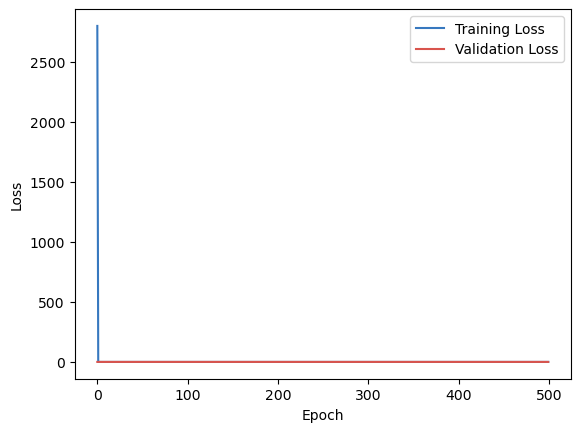

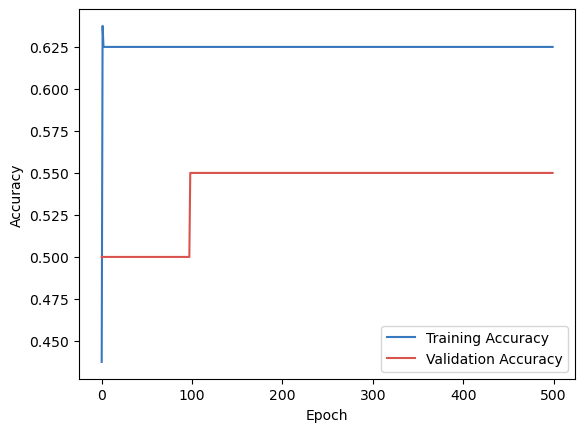

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/home/aurelien/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-10 12:12:47.765371: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1/Softmax' id:77 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


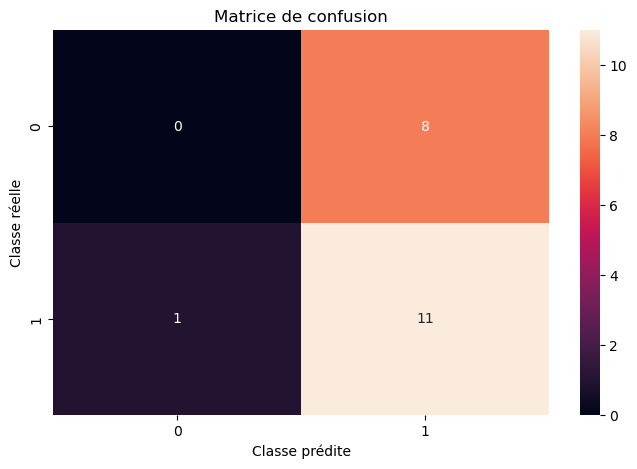

In [15]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()

### Modèle VGG19 - Softmax - Optimisation des hyperparamètres :

###### Reshaped des imageries pour l'utilisation du VGG19 :

In [19]:
X_train_reshaped = np.repeat(X_train, 3, axis = -1)
print("Shape X_train VGG19 :", X_train_reshaped.shape)

X_val_reshaped = np.repeat(X_val, 3, axis = -1)
print("Shape X_val VGG19   :", X_val_reshaped.shape)

X_reshaped = np.repeat(X, 3, axis = -1)
print("Shape X VGG19       :" ,X_reshaped.shape)

Shape X_train VGG19 : (80, 512, 512, 3)
Shape X_val VGG19   : (20, 512, 512, 3)
Shape X VGG19       : (100, 512, 512, 3)


###### Visualisation des imageries au format VGG19 :

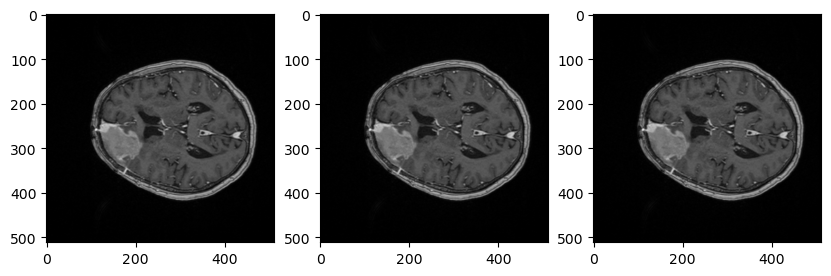

In [121]:
image = X_reshaped[5]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_IRMPre_softmax', dpi=400)

In [15]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner2 = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)


tuner2.search(X_train_reshaped, y_train, epochs=500, batch_size=len(y_train), validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])


Trial 101 Complete [00h 07m 29s]
val_binary_accuracy: 0.6499999761581421

Best val_binary_accuracy So Far: 0.8500000238418579
Total elapsed time: 12h 47m 11s


In [17]:
best_model = tuner2.get_best_models()[0]
best_model.summary()
best_hp=tuner2.get_best_hyperparameters()[0]

print(best_hp.values)
print(best_model.history)


2024-04-30 07:52:14.473567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 07:52:14.473810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 07:52:14.473978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-04-30 07:52:14.926890: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives_1/Assign' id:673 op device:{requested: '', assigned: ''} def:{{{node false_positives_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_1, false_positives_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [29]:
best_model.save('best_model_29042024/')

INFO:tensorflow:Assets written to: best_model_29042024/assets


INFO:tensorflow:Assets written to: best_model_29042024/assets


In [25]:
best_model = keras.models.load_model('best_model_29042024/')

2024-05-10 12:19:09.789372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:19:09.789589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:19:09.789734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

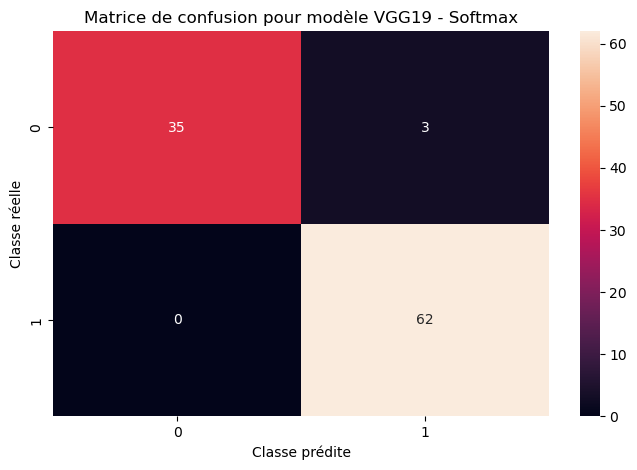

In [48]:
y_pred = best_model.predict(X_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 - Softmax')
plt.savefig('VGG19_Softmax', dpi = 400)
plt.show()

### Normalisation des données : Softmax 

In [10]:
def normalize(data):
    min=data.min()
    max=data.max()
    norm = (((data - min) / (max - min))).astype(np.uint8) 
    return preprocess_input(np.rint(norm))

In [20]:
X_train_reshaped_norm = normalize(X_train_shape)
X_val_reshaped_norm = normalize(X_val_shape)
X_reshaped_norm = normalize(X_shape)

In [12]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_softmax_norm = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_softmax_norm')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=100, restore_best_weights=True)


tuner_softmax_norm.search(X_train_reshaped_norm, y_train, epochs=500, batch_size=len(y_train), validation_data=(X_val_reshaped_norm, y_val), callbacks=[early_stopping]) 

best_model_softmax_norm = tuner_softmax_norm.get_best_models()[0]
best_model_softmax_norm.summary()
best_hp_softmax_norm = tuner_softmax_norm.get_best_hyperparameters()[0]

print(best_hp_softmax_norm.values)
print(best_model_softmax_norm.history)

Trial 101 Complete [00h 01m 47s]
val_binary_accuracy: 0.550000011920929

Best val_binary_accuracy So Far: 0.75
Total elapsed time: 2d 04h 32m 35s


2024-05-02 19:16:41.222686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 19:16:41.222945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 19:16:41.223111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-05-02 19:16:41.690786: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives/Assign' id:655 op device:{requested: '', assigned: ''} def:{{{node false_positives/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives, false_positives/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [13]:
best_model_softmax_norm.save('best_model_29042024_softmax_norm/')

INFO:tensorflow:Assets written to: best_model_29042024_softmax_norm/assets


INFO:tensorflow:Assets written to: best_model_29042024_softmax_norm/assets


In [54]:
best_model = keras.models.load_model('best_model_29042024_softmax_norm/')

2024-05-10 12:31:43.788052: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_129' id:2903 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_129}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_56, Identity_127)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


/home/aurelien/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-10 12:32:04.800070: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3_2/Softmax' id:3068 op device:{requested: '', assigned: ''} def:{{{node dense_3_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


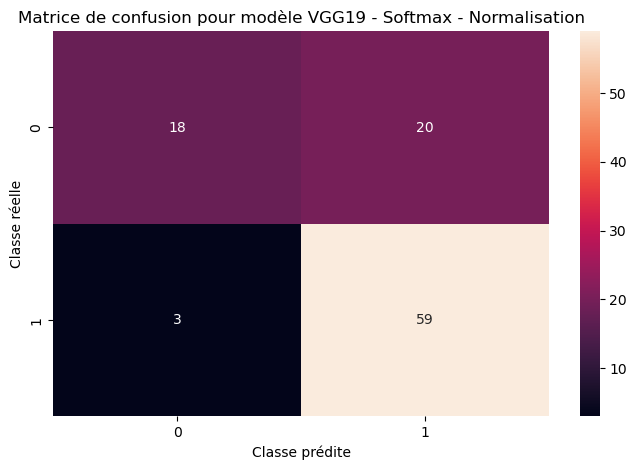

In [55]:
y_pred = best_model.predict(X_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 - Softmax - Normalisation')
plt.savefig('VGG19_Softmax_Normalisation', dpi = 400)
plt.show()

### Classification : Canaux (IRM-0-0) - VGG19 - Softmax

In [77]:
IRMpre_directory  = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/07_Classification_IRMpre"

Matrice_IRMpre_npy = []
Classification     = []

IRMpre = [f for f in os.listdir(IRMpre_directory) if f.endswith('.nii')]
    
for fichier in IRMpre:
    chemin_IRMpre        = os.path.join(IRMpre_directory, fichier)
    label_classification = chemin_IRMpre.split("_")[-4]

    image_IRM = nib.load(chemin_IRMpre)
        
    data = image_IRM.get_fdata()
        
    Matrice_IRMpre_npy.append(data)
    Classification.append(label_classification)
        
print("Nombre de matrices Numpy                 :", len(Matrice_IRMpre_npy))
print("Nombre de réponse pour la classification :", len(Classification))


X = np.array(Matrice_IRMpre_npy)
X = np.expand_dims(X, axis = -1)
X = np.repeat(X, 1, axis = -1)
y = np.array(Classification)



for i in range(len(y)):
    if y[i] == 'Long':
        y[i] = 1
    elif y[i] == 'Court':
        y[i] = 0

print('X shape', X.shape)
print('y shape', y.shape)

Nombre de matrices Numpy                 : 100
Nombre de réponse pour la classification : 100
X shape (100, 512, 512, 1)
y shape (100,)


###### Visualisation des imageries :

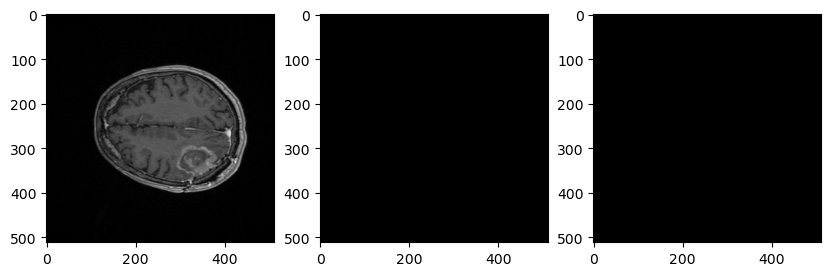

In [122]:
X_IRM_None_None = np.concatenate((X, X, X), axis=-1)
X_IRM_None_None = np.zeros_like(X_input)
X_IRM_None_None[:,:,:,0] = X_input[:,:,:,0]

image = X_IRM_None_None[0]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_IRMPreNoneNone_softmax', dpi=400)

In [79]:
X_train_IRM_None_None, X_val_IRM_None_None, y_train_IRM_None_None, y_val_IRM_None_None = train_test_split(X_IRM_None_None, y, test_size = 0.20, random_state = 2)
y_train_IRM_None_None = to_categorical(y_train_IRM_None_None, num_classes = 2)
y_val_IRM_None_None = to_categorical(y_val_IRM_None_None, num_classes = 2)
y = to_categorical(y, num_classes = 2)

print("\nX_train shape :", X_train_IRM_None_None.shape)
print("X_val shape   :", X_val_IRM_None_None.shape)
print("y_train shape :", y_train_IRM_None_None.shape)
print("y_val shape   :", y_val_IRM_None_None.shape)


X_train shape : (80, 512, 512, 3)
X_val shape   : (20, 512, 512, 3)
y_train shape : (80, 2)
y_val shape   : (20, 2)


In [223]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_IRM_None_None = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_IRM_None_None')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)

tuner_IRM_None_None.search(X_train_IRM_None_None, 
                           y_train_IRM_None_None, 
                           epochs=500, 
                           batch_size=len(y_train_IRM_None_None), 
                           validation_data=(X_val_IRM_None_None, y_val_IRM_None_None), 
                           callbacks=[early_stopping]) 


Trial 101 Complete [00h 03m 24s]
val_binary_accuracy: 0.6499999761581421

Best val_binary_accuracy So Far: 0.8500000238418579
Total elapsed time: 04h 47m 45s


In [224]:
best_model_IRM_None_None = tuner_IRM_None_None.get_best_models()[0]
best_model_IRM_None_None.summary()
best_hp_IRM_None_None = tuner_IRM_None_None.get_best_hyperparameters()[0]

print(best_hp_IRM_None_None.values)
print(best_model_IRM_None_None.history)

2024-05-08 00:03:20.068910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 00:03:20.069134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 00:03:20.069286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-05-08 00:03:20.512992: W tensorflow/c/c_api.cc:300] Operation '{name:'dense/bias/Assign' id:542 op device:{requested: '', assigned: ''} def:{{{node dense/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/bias, dense/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [225]:
best_model_IRM_None_None.save('best_hp_07052024_IRM_None_None/')

INFO:tensorflow:Assets written to: best_hp_07052024_IRM_None_None/assets


INFO:tensorflow:Assets written to: best_hp_07052024_IRM_None_None/assets


In [80]:
best_model = keras.models.load_model('best_hp_07052024_IRM_None_None/')

2024-05-10 12:51:47.308811: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_249' id:4956 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_249}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_88, Identity_247)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


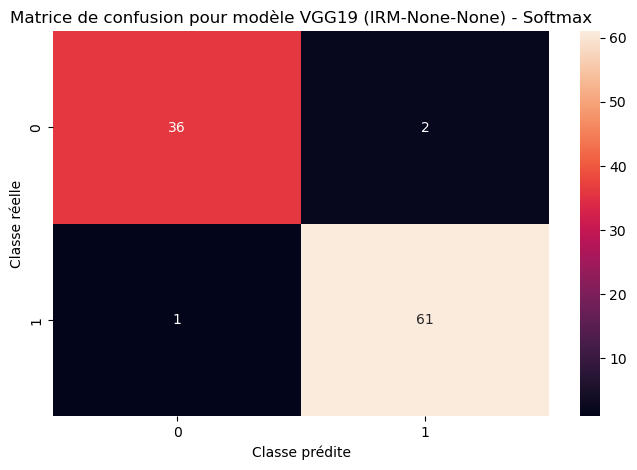

In [127]:
y_pred = best_model.predict(X_IRM_None_None)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 (IRM-None-None) - Softmax')
plt.savefig('VGG19_Softmax_IRMNoneNone', dpi = 400)
plt.show()

# Chargement et traitement des données - IRM Pré traitement + RTDOSE :

### Modèle VGG19 - 3 Canaux (IRM/RTDOSE/RTDOSE) - Softmax :

In [85]:
IRMpre_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/IRMPre"

IRMpre = [f for f in os.listdir(IRMpre_directory) if f.endswith('.nii')]

IRMpre_array = []
Matrice_IRMpre_npy = []
Classification     = []


def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in IRMpre:

    chemin_IRMpre        = os.path.join(IRMpre_directory, fichier)
    IRMpre_array.append(chemin_IRMpre) 
    
    sorted_chemin_IRMpre = sorted(IRMpre_array, key=sort_by_file_name)
    
for path in sorted_chemin_IRMpre:
    label_classification = path.split("_")[-4]

    image_IRM = nib.load(path)
        
    data = image_IRM.get_fdata()
    
    Matrice_IRMpre_npy.append(data)
    Classification.append(label_classification)

print("Nombre de matrices Numpy                 :", len(Matrice_IRMpre_npy))
print("Nombre de réponse pour la classification :", len(Classification))

X_IRM = np.array(Matrice_IRMpre_npy)
X_IRM = np.expand_dims(X_IRM, axis = -1)
X_IRM = np.repeat(X_IRM, 1, axis = -1)
y = np.array(Classification)


for i in range(len(y)):
    if y[i] == 'Long':
        y[i] = 1
    elif y[i] == 'Court':
        y[i] = 0
        
y = to_categorical(y)

Nombre de matrices Numpy                 : 100
Nombre de réponse pour la classification : 100


In [86]:
RTDOSE_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/RTDOSE"

RTDOSE = [f for f in os.listdir(RTDOSE_directory) if f.endswith('.nii')]

RTDOSE_array = []
Matrice_RTDOSE_npy = []

def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in RTDOSE:

    chemin_RTDOSE        = os.path.join(RTDOSE_directory, fichier)
    RTDOSE_array.append(chemin_RTDOSE) 
    
    sorted_chemin_RTDOSE = sorted(RTDOSE_array, key=sort_by_file_name)
    
for path in sorted_chemin_RTDOSE:

    image_RTDOSE = nib.load(path)
        
    data = image_RTDOSE.get_fdata()
    
    Matrice_RTDOSE_npy.append(data)

print("Nombre de matrices Numpy                 :", len(Matrice_RTDOSE_npy))

X_RTDOSE = np.array(Matrice_RTDOSE_npy)
X_RTDOSE = np.expand_dims(X_RTDOSE, axis = -1)
X_RTDOSE = np.repeat(X_RTDOSE, 1, axis = -1)

Nombre de matrices Numpy                 : 100


In [87]:
X_input = np.concatenate((X_IRM, X_RTDOSE, X_IRM), axis=-1)

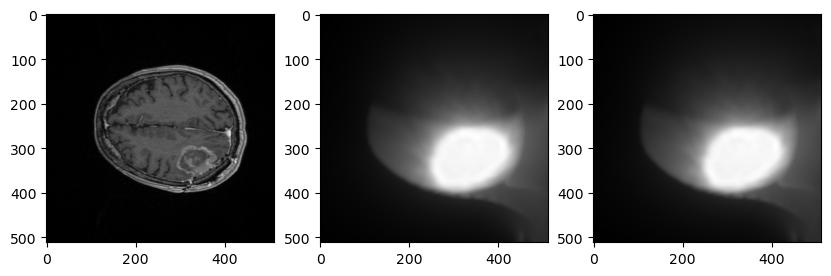

In [123]:
## Visualisation des images
image = X_input[0]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_IRMPreRTDOSERTDOSE_softmax', dpi=400)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X_input, y, test_size = 0.20, random_state = 2)

print("\nX_train shape :", X_train.shape)
print("X_val shape   :", X_val.shape)
print("y_train shape :", y_train.shape)
print("y_val shape   :", y_val.shape)


X_train shape : (80, 512, 512, 3)
X_val shape   : (20, 512, 512, 3)
y_train shape : (80, 2)
y_val shape   : (20, 2)


In [58]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_IRM_RTDOSE_IRM = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_IRM_RTDOSE_IRM')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)


tuner_IRM_RTDOSE_IRM.search(X_train, y_train, epochs=500, batch_size=len(y_train), validation_data=(X_val, y_val), callbacks=[early_stopping]) 


Trial 101 Complete [00h 02m 47s]
val_binary_accuracy: 0.75

Best val_binary_accuracy So Far: 0.75
Total elapsed time: 04h 20m 15s


In [59]:
best_model_IRM_RTDOSE_IRM = tuner_IRM_RTDOSE_IRM.get_best_models()[0]
best_model_IRM_RTDOSE_IRM.summary()
best_hp_IRM_RTDOSE_IRM = tuner_IRM_RTDOSE_IRM.get_best_hyperparameters()[0]

print(best_hp_IRM_RTDOSE_IRM.values)
print(best_model_IRM_RTDOSE_IRM.history)

2024-05-03 19:34:55.584461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 19:34:55.584735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 19:34:55.584917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-05-03 19:34:56.060674: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives_1/Assign' id:673 op device:{requested: '', assigned: ''} def:{{{node false_positives_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_1, false_positives_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [60]:
best_model_IRM_RTDOSE_IRM.save('best_model_03052024_softmax_IRM_RTDOSE_IRM/')

INFO:tensorflow:Assets written to: best_model_03052024_softmax_IRM_RTDOSE_IRM/assets


INFO:tensorflow:Assets written to: best_model_03052024_softmax_IRM_RTDOSE_IRM/assets


In [83]:
best_model_IRM_RTDOSE_IRM = keras.models.load_model('best_model_03052024_softmax_IRM_RTDOSE_IRM/')

2024-05-10 12:54:20.717991: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_277' id:5915 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_277}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_115, Identity_275)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


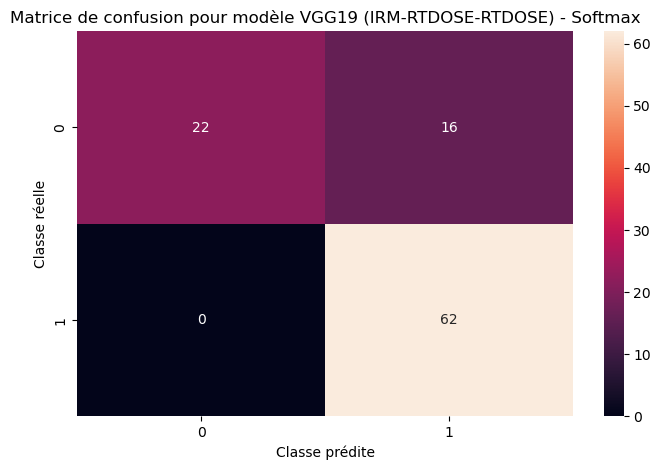

In [91]:
y_pred = best_model_IRM_RTDOSE_IRM.predict(X_input)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 (IRM-RTDOSE-RTDOSE) - Softmax')
plt.savefig('VGG19_Softmax_IRMRTDOSERTDOSE', dpi = 400)
plt.show()

### Modèle VGG19 - 3 Canaux (IRM*RTDOSE/IRM*RTDOSE/IRM*RTDOSE) - Softmax :

In [98]:
X_input_IRMxRTDOSE = np.concatenate((X_IRM*X_RTDOSE, X_IRM*X_RTDOSE, X_IRM*X_RTDOSE), axis=-1)
X_train, X_val, y_train, y_val = train_test_split(X_input_IRMxRTDOSE, y, test_size = 0.20, random_state = 2)

print("\nX_train shape :", X_train.shape)
print("X_val shape   :", X_val.shape)
print("y_train shape :", y_train.shape)
print("y_val shape   :", y_val.shape)


X_train shape : (80, 512, 512, 3)
X_val shape   : (20, 512, 512, 3)
y_train shape : (80, 2)
y_val shape   : (20, 2)


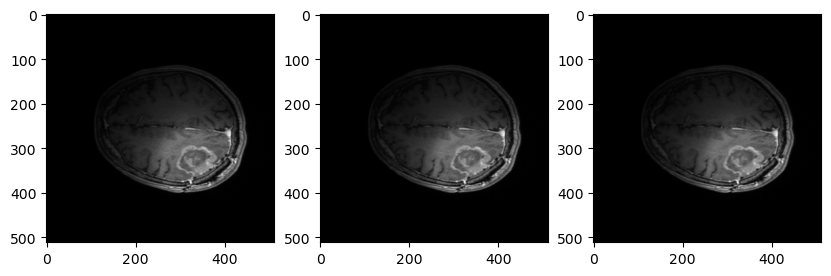

In [124]:
image = X_input_IRMxRTDOSE[0]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_IRMPrexRTDOSE_softmax', dpi=400)

In [66]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_IRMxRTDOSE = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_IRMxRTDOSE')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)


tuner_IRMxRTDOSE.search(X_train, y_train, epochs=500, batch_size=len(y_train), validation_data=(X_val, y_val), callbacks=[early_stopping]) 


Trial 101 Complete [00h 02m 50s]
val_binary_accuracy: 0.6000000238418579

Best val_binary_accuracy So Far: 0.800000011920929
Total elapsed time: 04h 29m 06s


In [67]:
best_model_IRMxRTDOSE = tuner_IRMxRTDOSE.get_best_models()[0]
best_model_IRMxRTDOSE.summary()
best_hp_IRMxRTDOSE = tuner_IRMxRTDOSE.get_best_hyperparameters()[0]

print(best_hp_IRMxRTDOSE.values)
print(best_model_IRMxRTDOSE.history)

2024-05-04 00:04:10.812200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 00:04:10.812469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 00:04:10.812648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
best_model_IRMxRTDOSE.save('best_model_03052024_softmax_IRMxRTDOSE/')

In [94]:
best_model_IRMxRTDOSE = keras.models.load_model('best_model_03052024_softmax_IRMxRTDOSE/')

2024-05-10 12:56:43.393405: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_326' id:6920 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_326}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_135, Identity_324)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


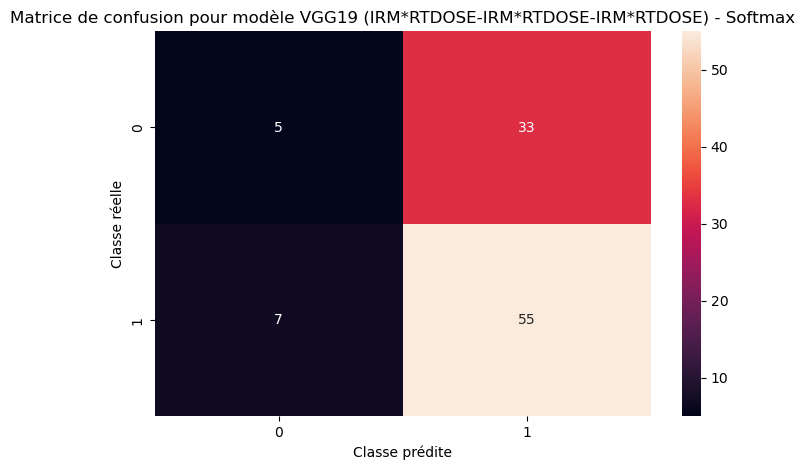

In [96]:
y_pred = best_model_IRM_RTDOSE_IRM.predict(X_input_IRMxRTDOSE)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 (IRM*RTDOSE-IRM*RTDOSE-IRM*RTDOSE) - Softmax')
plt.savefig('VGG19_Softmax_IRM*RTDOSE_IRM*RTDOSE_IRM*RTDOSE', dpi = 400)
plt.show()

### Modèle VGG19 - 3 Canaux (IRM*RTDOSE/None/None) - Softmax :

In [100]:
IRMpre_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/IRMPre"

IRMpre = [f for f in os.listdir(IRMpre_directory) if f.endswith('.nii')]

IRMpre_array = []
Matrice_IRMpre_npy = []
Classification     = []


def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in IRMpre:

    chemin_IRMpre        = os.path.join(IRMpre_directory, fichier)
    IRMpre_array.append(chemin_IRMpre) 
    
    sorted_chemin_IRMpre = sorted(IRMpre_array, key=sort_by_file_name)
    
for path in sorted_chemin_IRMpre:
    label_classification = path.split("_")[-4]

    image_IRM = nib.load(path)
        
    data = image_IRM.get_fdata()
    
    Matrice_IRMpre_npy.append(data)
    Classification.append(label_classification)

print("Nombre de matrices Numpy                 :", len(Matrice_IRMpre_npy))
print("Nombre de réponse pour la classification :", len(Classification))

X_IRM = np.array(Matrice_IRMpre_npy)
X_IRM = np.expand_dims(X_IRM, axis = -1)
X_IRM = np.repeat(X_IRM, 1, axis = -1)
y = np.array(Classification)


for i in range(len(y)):
    if y[i] == 'Long':
        y[i] = 1
    elif y[i] == 'Court':
        y[i] = 0
        


Nombre de matrices Numpy                 : 100
Nombre de réponse pour la classification : 100


In [101]:
RTDOSE_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/RTDOSE"

RTDOSE = [f for f in os.listdir(RTDOSE_directory) if f.endswith('.nii')]

RTDOSE_array = []
Matrice_RTDOSE_npy = []

def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in RTDOSE:

    chemin_RTDOSE        = os.path.join(RTDOSE_directory, fichier)
    RTDOSE_array.append(chemin_RTDOSE) 
    
    sorted_chemin_RTDOSE = sorted(RTDOSE_array, key=sort_by_file_name)
    
for path in sorted_chemin_RTDOSE:

    image_RTDOSE = nib.load(path)
        
    data = image_RTDOSE.get_fdata()
    
    Matrice_RTDOSE_npy.append(data)

print("Nombre de matrices Numpy                 :", len(Matrice_RTDOSE_npy))

X_RTDOSE = np.array(Matrice_RTDOSE_npy)
X_RTDOSE = np.expand_dims(X_RTDOSE, axis = -1)
X_RTDOSE = np.repeat(X_RTDOSE, 1, axis = -1)

Nombre de matrices Numpy                 : 100


In [102]:
X_IRMxRTDOSE_3canaux = np.concatenate((X_IRM*X_RTDOSE, X_IRM*X_RTDOSE,X_IRM*X_RTDOSE), axis=-1)

In [103]:
X_IRMxRTDOSE_None_None = np.zeros_like(X_IRMxRTDOSE_3canaux)
X_IRMxRTDOSE_None_None[:,:,:,0] = X_IRMxRTDOSE_3canaux[:,:,:,0]

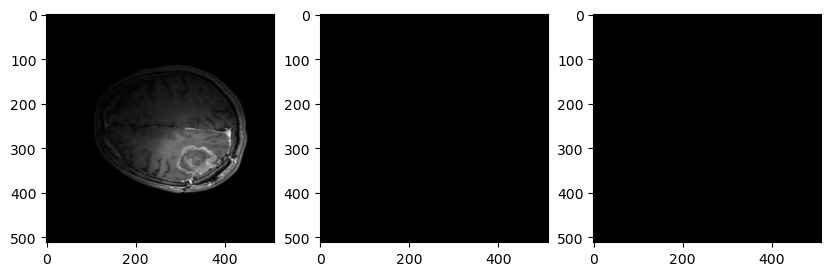

In [125]:
## Visualisation des images
image = X_IRMxRTDOSE_None_None[0]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_IRMPrexRTDOSENoneNone_softmax', dpi=400)

In [108]:
X_train_IRMxRTDOSE_None_None, X_val_IRMxRTDOSE_None_None, y_train_IRMxRTDOSE_None_None, y_val_IRMxRTDOSE_None_None = train_test_split(X_IRMxRTDOSE_None_None, y, test_size = 0.20, random_state = 2)
y_train_IRMxRTDOSE_None_None = to_categorical(y_train_IRMxRTDOSE_None_None, num_classes = 2)
y_val_IRMxRTDOSE_None_None = to_categorical(y_val_IRMxRTDOSE_None_None, num_classes = 2)
y = to_categorical(y, num_classes = 2)

print("\nX_train shape :", X_train_IRMxRTDOSE_None_None.shape)
print("X_val shape   :", X_val_IRMxRTDOSE_None_None.shape)
print("y_train shape :", y_train_IRMxRTDOSE_None_None.shape)
print("y_val shape   :", y_val_IRMxRTDOSE_None_None.shape)


X_train shape : (80, 512, 512, 3)
X_val shape   : (20, 512, 512, 3)
y_train shape : (80, 2)
y_val shape   : (20, 2)


In [232]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_IRMxRTDOSE_None_None = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_IRMxRTDOSE_None_None')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)

tuner_IRMxRTDOSE_None_None.search(X_train_IRMxRTDOSE_None_None, 
                           y_train_IRMxRTDOSE_None_None, 
                           epochs=500, 
                           batch_size=len(y_train_IRMxRTDOSE_None_None), 
                           validation_data=(X_val_IRMxRTDOSE_None_None, y_val_IRMxRTDOSE_None_None), 
                           callbacks=[early_stopping]) 


Trial 101 Complete [00h 02m 41s]
val_binary_accuracy: 0.699999988079071

Best val_binary_accuracy So Far: 0.800000011920929
Total elapsed time: 04h 27m 29s


In [233]:
best_model_IRMxRTDOSE_None_None = tuner_IRMxRTDOSE_None_None.get_best_models()[0]
best_model_IRMxRTDOSE_None_None.summary()
best_hp_IRMxRTDOSE_None_None = tuner_IRMxRTDOSE_None_None.get_best_hyperparameters()[0]

print(best_hp_IRMxRTDOSE_None_None.values)
print(best_model_IRMxRTDOSE_None_None.history)

2024-05-08 04:30:54.688788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:30:54.689059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:30:54.689222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-05-08 04:30:55.124462: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_2/kernel/Assign' id:599 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [234]:
best_model_IRMxRTDOSE_None_None.save('best_hp_07052024_IRMxRTDOSE_None_None/')

INFO:tensorflow:Assets written to: best_hp_07052024_IRMxRTDOSE_None_None/assets


INFO:tensorflow:Assets written to: best_hp_07052024_IRMxRTDOSE_None_None/assets


In [106]:
best_model_IRMxRTDOSE_None_None = keras.models.load_model('best_hp_07052024_IRMxRTDOSE_None_None/')

2024-05-10 13:38:09.702582: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_367' id:7916 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_367}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_150, Identity_365)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


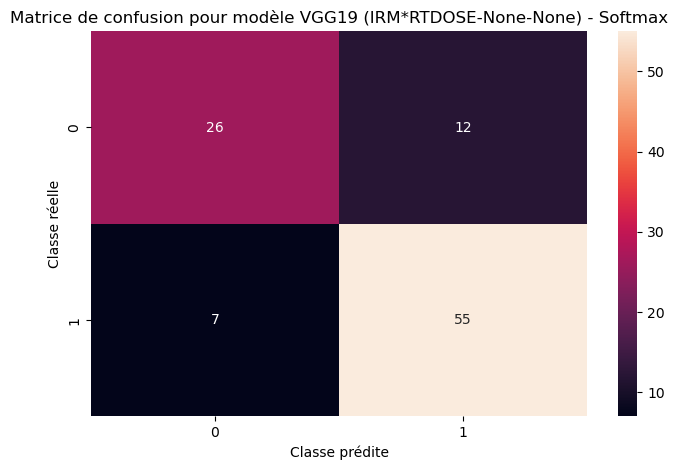

In [119]:
y_pred = best_model_IRMxRTDOSE_None_None.predict(X_IRMxRTDOSE_None_None)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 (IRM*RTDOSE-None-None) - Softmax')
plt.savefig('VGG19_Softmax_IRM*RTDOSE_None_None', dpi = 400)
plt.show()

### Modèle VGG19 - 3 Canaux (RTDOSE/IRM/IRM) - Softmax :

In [110]:
IRMpre_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/IRMPre"

IRMpre = [f for f in os.listdir(IRMpre_directory) if f.endswith('.nii')]

IRMpre_array = []
Matrice_IRMpre_npy = []
Classification     = []


def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in IRMpre:

    chemin_IRMpre        = os.path.join(IRMpre_directory, fichier)
    IRMpre_array.append(chemin_IRMpre) 
    
    sorted_chemin_IRMpre = sorted(IRMpre_array, key=sort_by_file_name)
    
for path in sorted_chemin_IRMpre:
    label_classification = path.split("_")[-4]

    image_IRM = nib.load(path)
        
    data = image_IRM.get_fdata()
    
    Matrice_IRMpre_npy.append(data)
    Classification.append(label_classification)

print("Nombre de matrices Numpy                 :", len(Matrice_IRMpre_npy))
print("Nombre de réponse pour la classification :", len(Classification))

X_IRM = np.array(Matrice_IRMpre_npy)
X_IRM = np.expand_dims(X_IRM, axis = -1)
X_IRM = np.repeat(X_IRM, 1, axis = -1)
y = np.array(Classification)


for i in range(len(y)):
    if y[i] == 'Long':
        y[i] = 1
    elif y[i] == 'Court':
        y[i] = 0

Nombre de matrices Numpy                 : 100
Nombre de réponse pour la classification : 100


In [111]:
RTDOSE_directory = "/home/aurelien/Documents/IA-Med-Im/Partie1_GBM_RT/06_Data_mri/RTDOSE"

RTDOSE = [f for f in os.listdir(RTDOSE_directory) if f.endswith('.nii')]

RTDOSE_array = []
Matrice_RTDOSE_npy = []

def sort_by_file_name(path):
    return os.path.basename(path)


for fichier in RTDOSE:

    chemin_RTDOSE        = os.path.join(RTDOSE_directory, fichier)
    RTDOSE_array.append(chemin_RTDOSE) 
    
    sorted_chemin_RTDOSE = sorted(RTDOSE_array, key=sort_by_file_name)
    
for path in sorted_chemin_RTDOSE:

    image_RTDOSE = nib.load(path)
        
    data = image_RTDOSE.get_fdata()
    
    Matrice_RTDOSE_npy.append(data)

print("Nombre de matrices Numpy                 :", len(Matrice_RTDOSE_npy))

X_RTDOSE = np.array(Matrice_RTDOSE_npy)
X_RTDOSE = np.expand_dims(X_RTDOSE, axis = -1)
X_RTDOSE = np.repeat(X_RTDOSE, 1, axis = -1)

Nombre de matrices Numpy                 : 100


In [112]:
X_RTDOSE_IRM_IRM = np.concatenate((X_RTDOSE, X_IRM, X_IRM), axis=-1)

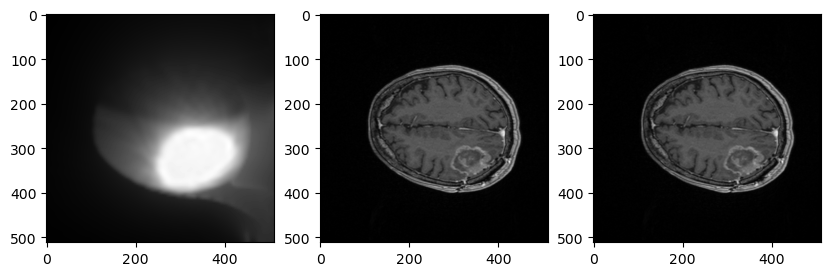

In [126]:
## Visualisation des images
image = X_RTDOSE_IRM_IRM[0]

red_channel   = image[:,:,0]
green_channel = image[:,:,1]
blue_channel  = image[:,:,2]

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=('gray'))

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=('gray'))

plt.subplot(1,3,3)
plt.imshow(green_channel, cmap=('gray'))

plt.savefig('VGG19_RTDOSEIRMPre_softmax', dpi=400)

In [114]:
X_train_RTDOSE_IRM_IRM, X_val_RTDOSE_IRM_IRM, y_train_RTDOSE_IRM_IRM, y_val_RTDOSE_IRM_IRM = train_test_split(X_RTDOSE_IRM_IRM, y, test_size = 0.20, random_state = 2)
y_train_RTDOSE_IRM_IRM = to_categorical(y_train_RTDOSE_IRM_IRM, num_classes = 2)
y_val_RTDOSE_IRM_IRM = to_categorical(y_val_RTDOSE_IRM_IRM, num_classes = 2)
y = to_categorical(y, num_classes=2)
print("\nX_train shape :", X_train_RTDOSE_IRM_IRM.shape)
print("X_val shape   :", X_val_RTDOSE_IRM_IRM.shape)
print("y_train shape :", y_train_RTDOSE_IRM_IRM.shape)
print("y_val shape   :", y_val_RTDOSE_IRM_IRM.shape)


X_train shape : (80, 512, 512, 3)
X_val shape   : (20, 512, 512, 3)
y_train shape : (80, 2)
y_val shape   : (20, 2)


In [242]:
def create_model(hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    base_model.layers
    for layer in base_model.layers:
        layer.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(hp.Choice('dense_units1', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation1", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units2', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation2", ["elu","gelu","relu","selu"]))(model)
    
    model = Dense(hp.Choice('dense_units3', [32, 64, 126, 258, 512, 1024, 2048, 4096]), 
                  activation=hp.Choice("activation3", ["elu","gelu","relu","selu"]))(model)
    
    predictions = Dense(2, activation='softmax')(model)

    
    metrics = [BinaryAccuracy(),Precision(name='precision'),Recall(name='recall'),AUC()] #F1Score()

    model = Model(inputs=base_model.input, outputs=predictions,)

    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = metrics)
    
    return model

tuner_RTDOSE_IRM_IRM = keras_tuner.RandomSearch(
    
    create_model,
    objective='val_binary_accuracy', #'binary_crossentropy', #loss
    max_trials=101,
    project_name='hyperparameters_RTDOSE_IRM_IRM')

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=150, restore_best_weights=True)

tuner_RTDOSE_IRM_IRM.search(X_train_RTDOSE_IRM_IRM, 
                           y_train_RTDOSE_IRM_IRM, 
                           epochs=500, 
                           batch_size=len(y_train_RTDOSE_IRM_IRM), 
                           validation_data=(X_val_RTDOSE_IRM_IRM, y_val_RTDOSE_IRM_IRM), 
                           callbacks=[early_stopping]) 


Trial 101 Complete [00h 02m 22s]
val_binary_accuracy: 0.6499999761581421

Best val_binary_accuracy So Far: 0.800000011920929
Total elapsed time: 04h 19m 40s


In [243]:
best_model_RTDOSE_IRM_IRM = tuner_RTDOSE_IRM_IRM.get_best_models()[0]
best_model_RTDOSE_IRM_IRM.summary()
best_hp_RTDOSE_IRM_IRM = tuner_RTDOSE_IRM_IRM.get_best_hyperparameters()[0]

print(best_hp_RTDOSE_IRM_IRM.values)
print(best_model_RTDOSE_IRM_IRM.history)

2024-05-08 08:50:40.778423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 08:50:40.778675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 08:50:40.778861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

2024-05-08 08:50:41.269472: W tensorflow/c/c_api.cc:300] Operation '{name:'dense/bias/Assign' id:542 op device:{requested: '', assigned: ''} def:{{{node dense/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/bias, dense/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [244]:
best_model_RTDOSE_IRM_IRM.save('best_hp_07052024_RTDOSE_IRM_IRM/')

INFO:tensorflow:Assets written to: best_hp_07052024_RTDOSE_IRM_IRM/assets


INFO:tensorflow:Assets written to: best_hp_07052024_RTDOSE_IRM_IRM/assets


In [116]:
best_model_RTDOSE_IRM_IRM = keras.models.load_model('best_hp_07052024_RTDOSE_IRM_IRM/')

2024-05-10 13:41:37.540682: W tensorflow/c/c_api.cc:300] Operation '{name:'AssignVariableOp_402' id:8901 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_402}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](count_17, Identity_400)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


/home/aurelien/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-10 13:42:37.717360: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3_8/Softmax' id:9106 op device:{requested: '', assigned: ''} def:{{{node dense_3_8/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


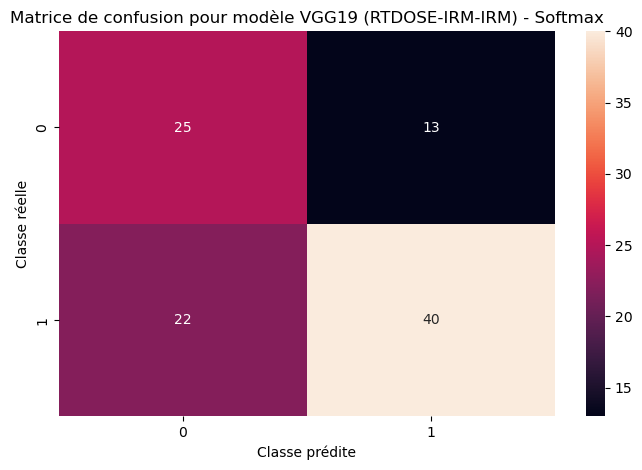

In [118]:
y_pred = best_model_RTDOSE_IRM_IRM.predict(X_RTDOSE_IRM_IRM)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion pour modèle VGG19 (RTDOSE-IRM-IRM) - Softmax')
plt.savefig('VGG19_Softmax_RTDOSE_IRM_IRM', dpi = 400)
plt.show()